# Constraint Satisfaction Problems
---
Constraint satisfaction is a general problem solving technique for solving a class of combinatorial optimization problems by imposing limits on the values in the solution. The goal of this exercise is to practice formulating some classical example problems as constraint satisfaction problems (CSPs), and then to explore using a powerful open source constraint satisfaction tool called [Z3](https://github.com/Z3Prover/z3) from Microsoft Research to solve them. Practicing with these simple problems will help you to recognize real-world problems that can be posed as CSPs; some solvers even have specialized utilities for specific types of problem (vehicle routing, planning, scheduling, etc.).

There are many different kinds of CSP solvers available for CSPs. Z3 is a "Satisfiability Modulo Theories" (SMT) solver, which means that unlike the backtracking and variable assignment heuristics discussed in lecture, Z3 first converts CSPs to satisfiability problems then uses a [boolean satisfiability](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem) (SAT) solver to determine feasibility. Z3 includes a number of efficient solver algorithms primarily developed to perform formal program verification, but it can also be used on general CSPs. Google's [OR tools](https://developers.google.com/optimization/) includes a CSP solver using backtracking with specialized subroutines for some common CP domains.

## I. The Road Ahead

0. [Cryptarithmetic](#I.-Cryptarithmetic) - introducing the Z3 API with simple word puzzles
0. [Map Coloring](#II.-Map-Coloring) - solving the map coloring problem from lectures
0. [N-Queens](#III.-N-Queens) - experimenting with problems that scale
0. [Revisiting Sudoku](#IV.-Revisiting-Sudoku) - revisit the sudoku project with the Z3 solver

<div class="alert alert-box alert-info">
NOTE: You can find solutions to this exercise in the "solutions" branch of the git repo, or on GitHub [here](https://github.com/udacity/artificial-intelligence/blob/solutions/Exercises/1_Constraint%20Satisfaction/AIND-Constraint_Satisfaction.ipynb).
</div>

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# from util import displayBoard
from itertools import product
from IPython.display import display
from z3 import *

---
## I. Cryptarithmetic

We'll start by exploring the Z3 module with a _very_ simple & classic CSP problem called cryptarithmetic. A cryptarithmetic puzzle is posed as an arithmetic equation made up of words where each letter represents a distinct digit in the range (0-9). (This problem has no practical significance in AI, but it is a useful illustration of the basic ideas of CSPs.) For example, consider the problem and one possible solution shown below:

```
  T W O  :    9 3 8
+ T W O  :  + 9 3 8
-------  :  -------
F O U R  :  1 8 7 6
```
There are six distinct variables (F, O, R, T, U, W), and when we require each letter to represent a disctinct number (e.g., F != O, R != T, ..., etc.) and disallow leading zeros (i.e., T != 0 and F != 0) then one possible solution is (F=1, O=8, R=6, T=9, U=7, W=3). 

### IMPLEMENTATION: Declaring Variables
For this problem we need a single variable for each distinct letter in the puzzle, and each variable will have an integer values between 0-9. (We will handle restricting the leading digits separately.) Complete the declarations in the next cell to create all of the remaining variables and constraint them to the range 0-9.

In [3]:
ca_solver = Solver()  # create an instance of a Z3 CSP solver

F = Int('F')  # create an z3.Int type variable instance called "F"
ca_solver.add(0 <= F, F <= 9)  # add constraints to the solver: 0 <= F <= 9

for letter in 'ORTUW':
    exec("{} = Int('{}')".format(letter, letter)) # create an z3.Int type variable instance

for z3_int in [O,R,T,U,W]:
    ca_solver.add(0 <= z3_int, z3_int <= 9)  # add constraints to the solver: 0 <= letter <= 9

In [4]:
ca_solver

[F >= 0,
 F <= 9,
 O >= 0,
 O <= 9,
 R >= 0,
 R <= 9,
 T >= 0,
 T <= 9,
 U >= 0,
 U <= 9,
 W >= 0,
 W <= 9]

### IMPLEMENTATION: Encoding Assumptions as Constraints
We had two additional assumptions that need to be added as constraints: 1) leading digits cannot be zero, and 2) no two distinct letters represent the same digits. The first assumption can simply be added as a boolean statement like M != 0. And the second is a _very_ common CSP constraint (so common, in fact, that most libraries have a built in function to support it); z3 is no exception, with the Distinct(var_list) constraint function.

In [5]:
# Add constraints prohibiting leading digits F & T from taking the value 0
ca_solver.add(F!=0)
ca_solver.add(T!=0)

# Add a Distinct constraint for all the variables
ca_solver.add(Distinct([F,O,R,T,U,W]))

In [6]:
ca_solver

[F >= 0,
 F <= 9,
 O >= 0,
 O <= 9,
 R >= 0,
 R <= 9,
 T >= 0,
 T <= 9,
 U >= 0,
 U <= 9,
 W >= 0,
 W <= 9,
 F != 0,
 T != 0,
 Distinct(F, O, R, T, U, W)]

### Choosing Problem Constraints
There are often multiple ways to express the constraints for a problem. For example, in this case we could write a single large constraint combining all of the letters simultaneously $T\times10^2 + W\times10^1 + O\times10^0 + T\times10^2 + W\times10^1 + O\times10^0 = F\times10^3 + O\times10^2 + U\times10^1 + R\times10^0$. This kind of constraint works fine for some problems, but large constraints cannot usually be evaluated for satisfiability unless every variable is bound to a specific value. Expressing the problem with smaller constraints can sometimes allow the solver to finish faster.

For example, we can break out each pair of digits in the summands and introduce a carry variable for each column: $(O + O)\times10^0 = R\times10^0 + carry_1\times10^1$ This constraint can be evaluated as True/False with only four values assigned.

The choice of encoding on this problem is unlikely to have any effect (because the problem is so small), however it is worth considering on more complex problems.

### Implementation: Add the Problem Constraints
Pick one of the possible encodings discussed above and add the required constraints into the solver in the next cell. 

In [7]:
# Add any required variables and/or constraints to solve the cryptarithmetic puzzle
# Primary solution using single constraint for the cryptarithmetic equation
ca_solver.add(((T + T)*10**2 + (W + W)*10**1 + (O + O)*10**0) == (F*10**3 + O*10**2 + U*10**1 + R*10**0))

In [8]:
ca_solver

[F >= 0,
 F <= 9,
 O >= 0,
 O <= 9,
 R >= 0,
 R <= 9,
 T >= 0,
 T <= 9,
 U >= 0,
 U <= 9,
 W >= 0,
 W <= 9,
 F != 0,
 T != 0,
 Distinct(F, O, R, T, U, W),
 (T + T)*100 + (W + W)*10 + (O + O)*1 ==
 F*1000 + O*100 + U*10 + R*1]

In [9]:
assert ca_solver.check() == sat, "Uh oh...the solver did not find a solution. Check your constraints."
print("  T W O  :    {} {} {}".format(ca_solver.model()[T], ca_solver.model()[W], ca_solver.model()[O]))
print("+ T W O  :  + {} {} {}".format(ca_solver.model()[T], ca_solver.model()[W], ca_solver.model()[O]))
print("-------  :  -------")
print("F O U R  :  {} {} {} {}".format(ca_solver.model()[F], ca_solver.model()[O], ca_solver.model()[U], ca_solver.model()[R]))

  T W O  :    8 4 6
+ T W O  :  + 8 4 6
-------  :  -------
F O U R  :  1 6 9 2


### Cryptarithmetic Challenges
0. Search online for [more cryptarithmetic puzzles](https://www.reddit.com/r/dailyprogrammer/comments/7p5p2o/20180108_challenge_346_easy_cryptarithmetic_solver/) (or create your own). Come to office hours or join a discussion channel to chat with your peers about the trade-offs between monolithic constraints & splitting up the constraints. (Is one way or another easier to generalize or scale with new problems? Is one of them faster for large or small problems?)
0. Can you extend the solution to handle complex puzzles (e.g., using multiplication WORD1 x WORD2 = OUTPUT)?

#### Other Example

```
  S E N D  :    9 5 7 9
+ M O R E  :  + 1 0 8 5
---------  :  ---------
M O N E Y  :  1 0 6 5 2
```

In [10]:
ca_solver = Solver()  # create an instance of a Z3 CSP solver

for letter in 'SENDMORY':
    exec("{} = Int('{}')".format(letter, letter)) # create an z3.Int type variable instance

for z3_int in [S,E,N,D,M,O,R,Y]:
    ca_solver.add(0 <= z3_int, z3_int <= 9)  # add constraints to the solver: 0 <= letter <= 9

In [11]:
# Add constraints prohibiting leading digits F & T from taking the value 0
ca_solver.add(S!=0)
ca_solver.add(M!=0)

# Add a Distinct constraint for all the variables
ca_solver.add(Distinct([S,E,N,D,M,O,R,Y]))

In [12]:
ca_solver.add(((S + M)*10**3 + (E + O)*10**2 + (N + R)*10**1 + (D + E)*10**0) == (M*10**4 + O*10**3 + N*10**2 + E*10**1 + Y*10**0))

In [15]:
assert ca_solver.check() == sat, "Uh oh...the solver did not find a solution. Check your constraints."
print("  S E N D  :    {} {} {} {}".format(ca_solver.model()[S], ca_solver.model()[E], ca_solver.model()[N], ca_solver.model()[D]))
print("+ M O R E  :  + {} {} {} {}".format(ca_solver.model()[M], ca_solver.model()[O], ca_solver.model()[R], ca_solver.model()[E]))
print("---------  :  -------------")
print("M O N E Y  :  {} {} {} {} {}".format(ca_solver.model()[M], ca_solver.model()[O], ca_solver.model()[N], ca_solver.model()[E], ca_solver.model()[Y]))

  S E N D  :    9 5 6 7
+ M O R E  :  + 1 0 8 5
---------  :  -------------
M O N E Y  :  1 0 6 5 2


#### Other Example

```
        T E N
+ H E R O N S
+     R E S T
+     N E A R
+   N O R T H
+       S E A
+   S H O R E
+         A S
+       T A N
+   T E R N S
+     S O A R
+         T O
+   E N T E R
+   T H E R E
+         A S
+ H E R O N S
+     N E S T
+         O N
+ S T O N E S
+         A T
+   S H O R E
+   T H R E E
+   S T A R S
+       A R E
+     S E E N
+     T E R N
+ S N O R E S
+       A R E
+     N E A R
-------------
S E V V O T H
```

In [3]:
equation = "TEN + HERONS + REST + NEAR + NORTH + SEA + SHORE + AS + TAN + TERNS + SOAR + TO + ENTER + THERE + AS + HERONS + NEST + ON + STONES + AT + SHORE + THREE + STARS + ARE + SEEN + TERN + SNORES + ARE + NEAR == SEVVOTH"

In [4]:
import re

In [5]:
# Find all different letters in the equation
pattern = re.compile('[A-Z]+')
words = pattern.findall(equation)
letters = set(''.join(words))
letters

{'A', 'E', 'H', 'N', 'O', 'R', 'S', 'T', 'V'}

In [6]:
ca_solver = Solver()  # create an instance of a Z3 CSP solver

In [7]:
# Create dictionnary of z3.Int type variable
int_dict = dict()
for letter in letters:
    exec("int_dict['{}'] = Int('{}')".format(letter, letter)) # create an z3.Int type variable instance

In [8]:
# Add constraint that each letter represent a digit (0-9)
for letter in letters:
    ca_solver.add(0 <= int_dict[letter], int_dict[letter] <= 9)

In [9]:
# Find all leading letters
pattern = re.compile('(\+){0,1}( )+([A-Z]){1}')
first_letters = set([x[2] for x in pattern.findall(equation)]).union(set('T'))
first_letters

{'A', 'E', 'H', 'N', 'O', 'R', 'S', 'T'}

In [10]:
# Leading zeroes are not allowed in a valid solution.
for letter in first_letters:
    ca_solver.add(int_dict[letter] != 0)

In [11]:
# Add a Distinct constraint for all the variables
ca_solver.add(Distinct(list(int_dict.values())))

In [12]:
ca_solver

[A >= 0,
 A <= 9,
 R >= 0,
 R <= 9,
 S >= 0,
 S <= 9,
 H >= 0,
 H <= 9,
 T >= 0,
 T <= 9,
 O >= 0,
 O <= 9,
 E >= 0,
 E <= 9,
 N >= 0,
 N <= 9,
 V >= 0,
 V <= 9,
 A != 0,
 R != 0,
 S != 0,
 H != 0,
 T != 0,
 O != 0,
 E != 0,
 N != 0,
 Distinct(A, R, S, H, T, O, E, N, V)]

In [13]:
equation

'TEN + HERONS + REST + NEAR + NORTH + SEA + SHORE + AS + TAN + TERNS + SOAR + TO + ENTER + THERE + AS + HERONS + NEST + ON + STONES + AT + SHORE + THREE + STARS + ARE + SEEN + TERN + SNORES + ARE + NEAR == SEVVOTH'

In [14]:
from collections import Counter

# Count occurence of each letter per power of 10
unit = dict()
for i in range(max(map(len, words))):
    count = Counter([x.rjust(7)[-(i+1)] for x in words[:-1] if x.rjust(7)[-(i+1)] != ' '])
    if len(count) > 0:
        unit[i] = dict(count)

In [15]:
unit

{0: {'N': 5, 'S': 8, 'T': 3, 'R': 4, 'H': 1, 'A': 1, 'E': 6, 'O': 1},
 1: {'E': 7, 'N': 3, 'S': 2, 'A': 7, 'T': 2, 'R': 7, 'O': 1},
 2: {'T': 3, 'O': 5, 'E': 7, 'R': 4, 'S': 1, 'N': 1, 'A': 3},
 3: {'R': 3, 'N': 4, 'O': 3, 'H': 4, 'E': 1, 'S': 2, 'T': 2},
 4: {'E': 3, 'N': 2, 'S': 3, 'T': 4},
 5: {'H': 2, 'S': 2}}

In [20]:
s = ""
for i in unit.keys():
    sub = ""
    for l, v in unit[i].items():
        sub = sub + " + "
        sub = sub + "int_dict['{}'] * {}".format(l, v)
    if i == 0:
        s = s + "(" + sub[3:] + ") * 10**{}".format(i)
    else:
        s = s + "+ (" + sub[3:] + ") * 10**{}".format(i)

In [21]:
s = "(" + s + ")" + " == (" + "int_dict['S']*10**6 + int_dict['E']*10**5 + int_dict['V']*10**4 + int_dict['V']*10**3 + int_dict['O']*10**2 + int_dict['T']*10**1 + int_dict['H']*10**0" + ")"

In [22]:
# Equation constraint to solve
exec("ca_solver.add({})".format(s))

In [23]:
ca_solver

[A >= 0,
 A <= 9,
 R >= 0,
 R <= 9,
 S >= 0,
 S <= 9,
 H >= 0,
 H <= 9,
 T >= 0,
 T <= 9,
 O >= 0,
 O <= 9,
 E >= 0,
 E <= 9,
 N >= 0,
 N <= 9,
 V >= 0,
 V <= 9,
 A != 0,
 R != 0,
 S != 0,
 H != 0,
 T != 0,
 O != 0,
 E != 0,
 N != 0,
 Distinct(A, R, S, H, T, O, E, N, V),
 ... + ... + ... + ... + ... + ... == ...]

In [27]:
s

"((int_dict['N'] * 5 + int_dict['S'] * 8 + int_dict['T'] * 3 + int_dict['R'] * 4 + int_dict['H'] * 1 + int_dict['A'] * 1 + int_dict['E'] * 6 + int_dict['O'] * 1) * 10**0+ (int_dict['E'] * 7 + int_dict['N'] * 3 + int_dict['S'] * 2 + int_dict['A'] * 7 + int_dict['T'] * 2 + int_dict['R'] * 7 + int_dict['O'] * 1) * 10**1+ (int_dict['T'] * 3 + int_dict['O'] * 5 + int_dict['E'] * 7 + int_dict['R'] * 4 + int_dict['S'] * 1 + int_dict['N'] * 1 + int_dict['A'] * 3) * 10**2+ (int_dict['R'] * 3 + int_dict['N'] * 4 + int_dict['O'] * 3 + int_dict['H'] * 4 + int_dict['E'] * 1 + int_dict['S'] * 2 + int_dict['T'] * 2) * 10**3+ (int_dict['E'] * 3 + int_dict['N'] * 2 + int_dict['S'] * 3 + int_dict['T'] * 4) * 10**4+ (int_dict['H'] * 2 + int_dict['S'] * 2) * 10**5) == (int_dict['S']*10**6 + int_dict['E']*10**5 + int_dict['V']*10**4 + int_dict['V']*10**3 + int_dict['O']*10**2 + int_dict['T']*10**1 + int_dict['H']*10**0)"

In [24]:
assert ca_solver.check() == sat, "Uh oh...the solver did not find a solution. Check your constraints."

In [31]:
letters

{'A', 'E', 'H', 'N', 'O', 'R', 'S', 'T', 'V'}

In [32]:
ans = dict()
for letter in letters:
    ans[letter] = ca_solver.model()[int_dict[letter]]

In [33]:
ans

{'A': 2, 'R': 6, 'S': 1, 'H': 3, 'T': 9, 'O': 4, 'E': 5, 'N': 7, 'V': 8}

In [36]:
help(str.replace)

Help on method_descriptor:

replace(self, old, new, count=-1, /)
    Return a copy with all occurrences of substring old replaced by new.
    
      count
        Maximum number of occurrences to replace.
        -1 (the default value) means replace all occurrences.
    
    If the optional argument count is given, only the first count occurrences are
    replaced.



In [44]:
eq = equation
for letter in letters:
    eq = eq.replace(letter, str(ans[letter]))

In [48]:
exec("print({})".format(eq))

True


--- ---
--- ---
# ---
## II. Map Coloring

[Map coloring](https://en.wikipedia.org/wiki/Map_coloring) is a classic example of CSPs. A map coloring problem is specified by a set of colors and a map showing the borders between distinct regions. A solution to a map coloring problem is an assignment of one color to each region of the map such that no pair of adjacent regions have the same color.

Run the first cell below to declare the color palette and a solver. The color palette specifies a mapping from integer to color. We'll use integers to represent the values in each constraint; then we can decode the solution from Z3 to determine the color applied to each region in the map.

![Map coloring is a classic example CSP](map.png)

In [111]:
# create instance of Z3 solver & declare color palette
mc_solver = Solver()
colors = {'0': "Blue", '1': "Red", '2': "Green"}

### IMPLEMENTATION: Add Variables
Add a variable to represent each region on the map above. Use the abbreviated name for the regions: WA=Western Australia, SA=Southern Australia, NT=Northern Territory, Q=Queensland, NSW=New South Wales, V=Victoria, T=Tasmania. Add constraints to each variable to restrict it to one of the available colors: 0=Blue, 1=Red, 2=Green.

In [112]:
WA = Int('WA')
mc_solver.add(0 <= WA, WA <= 2)

# TODO: add the remaining six regions and color constraints
SA = Int('SA')
mc_solver.add(0 <= SA, SA <= 2)

NT = Int('NT')
mc_solver.add(0 <= NT, NT <= 2)

Q = Int('Q')
mc_solver.add(0 <= Q, Q <= 2)

NSW = Int('NSW')
mc_solver.add(0 <= NSW, NSW <= 2)

V = Int('V')
mc_solver.add(0 <= V, V <= 2)

T = Int('T')
mc_solver.add(0 <= T, T <= 2)

In [113]:
regions = ["WA", "SA", "NT", "Q", "NSW", "V", "T"]

In [114]:
# Create dictionnary of z3.Int type variable
int_region = dict()
for region in regions:
    exec("int_region['{}'] = Int('{}')".format(region, region)) # create an z3.Int type variable instance

In [115]:
# Add color constraints
for region in regions:
    mc_solver.add(0 <= int_region[region], int_region[region] <= 2)

In [116]:
mc_solver

[WA >= 0,
 WA <= 2,
 SA >= 0,
 SA <= 2,
 NT >= 0,
 NT <= 2,
 Q >= 0,
 Q <= 2,
 NSW >= 0,
 NSW <= 2,
 V >= 0,
 V <= 2,
 T >= 0,
 T <= 2,
 WA >= 0,
 WA <= 2,
 SA >= 0,
 SA <= 2,
 NT >= 0,
 NT <= 2,
 Q >= 0,
 Q <= 2,
 NSW >= 0,
 NSW <= 2,
 V >= 0,
 V <= 2,
 T >= 0,
 T <= 2]

### IMPLEMENTATION: Distinct Adjacent Colors Constraints
As in the previous example, there are many valid ways to add constraints that enforce assigning different colors to adjacent regions of the map. One way is to add boolean constraints for each pair of adjacent regions, e.g., WA != SA; WA != NT; etc.

Another way is to use so-called pseudo-boolean cardinality constraint, which is a constraint of the form $ \sum w_i l_i = k $. Constraints of this form can be created in Z3 using `PbEq(((booleanA, w_A), (booleanB, w_B), ...), k)`. Distinct neighbors can be written with k=0, and w_i = 1 for all values of i. (Note: Z3 also has `PbLe()` for $\sum w_i l_i <= k $ and `PbGe()` for $\sum w_i l_i >= k $)

Choose one of the encodings discussed above and add the required constraints to the solver in the next cell.

In [117]:
mc_solver.add(PbEq(((WA == NT, 1), (WA == SA, 1)), 0))
mc_solver.add(PbEq(((NT == Q, 1), (NT == SA, 1)), 0))
mc_solver.add(PbEq(((SA == Q, 1), (SA == V, 1), (SA == NSW, 1)), 0))
mc_solver.add(Q != NSW)
mc_solver.add(NSW != V)

In [118]:
assert mc_solver.check() == sat, "Uh oh. The solver failed to find a solution. Check your constraints."
print("WA={}".format(colors[mc_solver.model()[WA].as_string()]))
print("NT={}".format(colors[mc_solver.model()[NT].as_string()]))
print("SA={}".format(colors[mc_solver.model()[SA].as_string()]))
print("Q={}".format(colors[mc_solver.model()[Q].as_string()]))
print("NSW={}".format(colors[mc_solver.model()[NSW].as_string()]))
print("V={}".format(colors[mc_solver.model()[V].as_string()]))
print("T={}".format(colors[mc_solver.model()[T].as_string()]))

WA=Red
NT=Green
SA=Blue
Q=Red
NSW=Green
V=Red
T=Blue


![Map coloring is a classic example CSP](map.png)

#### Map Coloring Challenge Problems
1. Generalize the procedure for this problem and try it on a larger map (countries in Africa, states in the USA, etc.)
2. Extend your procedure to perform [graph coloring](https://en.wikipedia.org/wiki/Graph_coloring) (maps are planar graphs; extending to all graphs generalizes the concept of "neighbors" to any pair of connected nodes). (Note: graph coloring is [NP-hard](https://en.wikipedia.org/wiki/Graph_coloring#Computational_complexity), so it may take a very long time to color large graphs.)

---
## III. N-Queens

In the next problem domain you'll solve the 8-queens puzzle, then use it to explore the complexity of solving CSPs. The 8-queens problem asks you to place 8 queens on a standard 8x8 chessboard such that none of the queens are in "check" (i.e., no two queens occupy the same row, column, or diagonal). The N-queens problem generalizes the puzzle to to any size square board.

![The 8-queens problem is another classic CSP example](EightQueens.gif)

There are many acceptable ways to represent the N-queens problem, but one convenient way is to recognize that one of the constraints (either the row or column constraint) can be enforced implicitly by the encoding.  If we represent a solution as an array with N elements, then each position in the array can represent a column of the board, and the value at each position can represent which row the queen is placed on.

In this encoding, we only need a constraint to make sure that no two queens occupy the same row, and one to make sure that no two queens occupy the same diagonal.

#### IMPLEMENTATION: N-Queens Solver
Complete the function below to take an integer N >= 5 and return a Z3 solver instance with appropriate constraints to solve the N-Queens problem. NOTE: it may take a few minutes for the solver to complete the suggested sizes below.

In [19]:
def Abs(x):
    return If(x >= 0, x, -x)

def nqueens(N):
    n_queen_solver = Solver() # define solver problem
    queens = [Int("Q{}".format(i)) for i in range(N)] # define N queens position
    # valide positions between 0 and N
    for queen in queens:
        n_queen_solver.add(0<=queen, queen<N)
    # not in the same row
    n_queen_solver.add(Distinct(queens))
    # not in the same diagonal
    for i,queen1 in enumerate(queens):
        for j, queen2 in enumerate(queens):
            if i != j:
                n_queen_solver.add(Abs(queen1-queen2) != abs(i-j))
    return n_queen_solver

8-queens: 29.887750999932905ms
16-queens: 309.6816669999498ms
32-queens: 1243.3979360000649ms
64-queens: 27323.886811999953ms


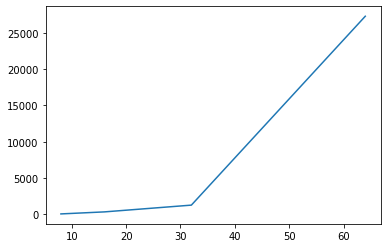

In [20]:
import time
from itertools import chain

runtimes = []
solutions = []
sizes = [8, 16, 32, 64]

for N in sizes:
    nq_solver = nqueens(N)
    start = time.perf_counter()
    assert nq_solver.check(), "Uh oh...The solver failed to find a solution. Check your constraints."
    end = time.perf_counter()
    print("{}-queens: {}ms".format(N, (end-start) * 1000))
    runtimes.append((end - start) * 1000)
    solutions.append(nq_solver)

plt.plot(sizes, runtimes)

### Queen Problem Challenges
- Extend the loop to run several times and estimate the variance in the solver. How consistent is the solver timing between runs?
- Read the `displayBoard()` function in the `util.py` module and use it to show your N-queens solution.

In [21]:
N = 8

In [22]:
nq_solver = nqueens(N)

In [53]:
s = solutions[0]

In [86]:
loc = [(int(str(s.model()[Int("Q{}".format(i))])), i) for i in range(N)]

In [87]:
loc

[(3, 0), (1, 1), (6, 2), (2, 3), (5, 4), (7, 5), (4, 6), (0, 7)]

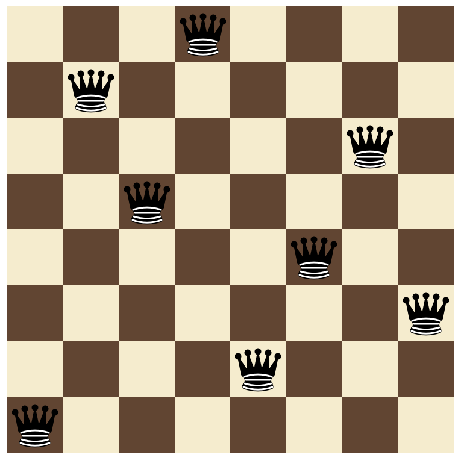

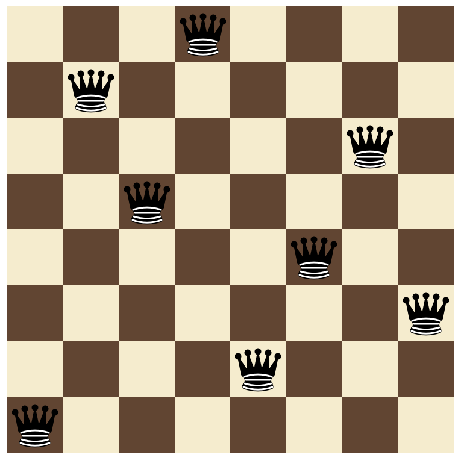

In [88]:
from util import displayBoard
displayBoard(loc, N)

---
## IV. Revisiting Sudoku
For the last CSP we'll revisit Sudoku from the first project. You previously solved Sudoku using backtracking search with constraint propagation. This time you'll re-write your solver using Z3. The backtracking search solver relied on domain-specific heuristics to select assignments during search, and to apply constraint propagation strategies (like elimination, only-choice, naked twins, etc.). The Z3 solver does not incorporate any domain-specific information, but makes up for that by incorporating a more sophisticated and a compiled solver routine.

![Example of an easy sudoku puzzle](sudoku.png)

In [131]:
from itertools import chain  # flatten nested lists; chain(*[[a, b], [c, d], ...]) == [a, b, c, d, ...]
rows = 'ABCDEFGHI'
cols = '123456789'
boxes = [Int("{}{}".format(r, c)) for r in rows for c in cols]  # declare variables for each box in the puzzle
s_solver = Solver()  # create a solver instance

In [133]:
row = [[Int("{}{}".format(r,c)) for c in cols] for r in rows]
col = [[Int("{}{}".format(r,c)) for r in rows] for c in cols]
box = [[Int("{}{}".format(r, c)) for r in rs for c in cs] for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')]

#### IMPLEMENTATION: General Constraints
Add constraints for each of the following conditions:
- Boxes can only have values between 1-9 (inclusive)
- Each box in a row must have a distinct value
- Each box in a column must have a distinct value
- Each box in a 3x3 block must have a distinct value

In [134]:
# TODO: Add constraints that every box has a value between 1-9 (inclusive)
s_solver.add(*chain(*[(1 <= b, b <= 9) for b in boxes]))

# TODO: Add constraints that every box in a row has a distinct value
s_solver.add(*[Distinct(r) for r in row])

# TODO: Add constraints that every box in a column has a distinct value
s_solver.add(*[Distinct(c) for c in col])

# TODO: Add constraints so that every box in a 3x3 block has a distinct value
s_solver.add(*[Distinct(b) for b in box])

#### IMPLMENTATION: Puzzle-Specific Constraints
Given the hints provided in the initial puzzle layout, you must also add constraints binding the box values to the specified values. For example, to solve the example puzzle you must specify A3 == 3 and B1 == 9, etc. The cells with a value of zero in the board below are "blank", so you should **not** create any constraint with the associate box.

In [143]:
# use the value 0 to indicate that a box does not have an assigned value
board = ((0, 0, 3, 0, 2, 0, 6, 0, 0),
         (9, 0, 0, 3, 0, 5, 0, 0, 1),
         (0, 0, 1, 8, 0, 6, 4, 0, 0),
         (0, 0, 8, 1, 0, 2, 9, 0, 0),
         (7, 0, 0, 0, 0, 0, 0, 0, 8),
         (0, 0, 6, 7, 0, 8, 2, 0, 0),
         (0, 0, 2, 6, 0, 9, 5, 0, 0),
         (8, 0, 0, 2, 0, 3, 0, 0, 9),
         (0, 0, 5, 0, 1, 0, 3, 0, 0))

values = dict(zip(boxes, [x for l in board for x in l]))
# TODO: Add constraints boxes[i][j] == board[i][j] for each box where board[i][j] != 0
s_solver.add(*[k==v for k,v in values.items() if v!=0])

In [ ]:
assert s_solver.check() == sat, "Uh oh. The solver didn't find a solution. Check your constraints."

In [194]:
values = dict()
for box in boxes:
    values[str(box)]=s_solver.model()[box].as_string()

In [195]:
from util import display_sudoku
display_sudoku(values)

4 8 3 |9 2 1 |6 5 7 
9 6 7 |3 4 5 |8 2 1 
2 5 1 |8 7 6 |4 9 3 
------+------+------
5 4 8 |1 3 2 |9 7 6 
7 2 9 |5 6 4 |1 3 8 
1 3 6 |7 9 8 |2 4 5 
------+------+------
3 7 2 |6 8 9 |5 1 4 
8 1 4 |2 5 3 |7 6 9 
6 9 5 |4 1 7 |3 8 2 



#### Sudoku Challenges
1. Solve the "[hardest sudoku puzzle](# https://www.telegraph.co.uk/news/science/science-news/9359579/Worlds-hardest-sudoku-can-you-crack-it.html)"
2. Search for "3d Sudoku rules", then extend your solver to handle 3d puzzles

#### Hardest Soduku Puzzle in the world

In [196]:
from itertools import chain  # flatten nested lists; chain(*[[a, b], [c, d], ...]) == [a, b, c, d, ...]
rows = 'ABCDEFGHI'
cols = '123456789'
boxes = [Int("{}{}".format(r, c)) for r in rows for c in cols]  # declare variables for each box in the puzzle
s_solver = Solver()  # create a solver instance

In [197]:
row = [[Int("{}{}".format(r,c)) for c in cols] for r in rows]
col = [[Int("{}{}".format(r,c)) for r in rows] for c in cols]
box = [[Int("{}{}".format(r, c)) for r in rs for c in cs] for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')]

In [198]:
# TODO: Add constraints that every box has a value between 1-9 (inclusive)
s_solver.add(*chain(*[(1 <= b, b <= 9) for b in boxes]))

# TODO: Add constraints that every box in a row has a distinct value
s_solver.add(*[Distinct(r) for r in row])

# TODO: Add constraints that every box in a column has a distinct value
s_solver.add(*[Distinct(c) for c in col])

# TODO: Add constraints so that every box in a 3x3 block has a distinct value
s_solver.add(*[Distinct(b) for b in box])

In [199]:
# use the value 0 to indicate that a box does not have an assigned value
board = ((8, 0, 0, 0, 0, 0, 0, 0, 0),
         (0, 0, 3, 6, 0, 0, 0, 0, 0),
         (0, 7, 0, 0, 9, 0, 2, 0, 0),
         (0, 5, 0, 0, 0, 7, 0, 0, 0),
         (0, 0, 0, 0, 4, 5, 7, 0, 0),
         (0, 0, 0, 1, 0, 0, 0, 3, 0),
         (0, 0, 1, 0, 0, 0, 0, 6, 8),
         (0, 0, 8, 5, 0, 0, 0, 1, 0),
         (0, 9, 0, 0, 0, 0, 4, 0, 0))

values = dict(zip(boxes, [x for l in board for x in l]))
# TODO: Add constraints boxes[i][j] == board[i][j] for each box where board[i][j] != 0
s_solver.add(*[k==v for k,v in values.items() if v!=0])

In [200]:
assert s_solver.check() == sat, "Uh oh. The solver didn't find a solution. Check your constraints."

In [201]:
values = dict()
for box in boxes:
    values[str(box)]=s_solver.model()[box].as_string()

In [202]:
display_sudoku(values)

8 1 2 |7 5 3 |6 4 9 
9 4 3 |6 8 2 |1 7 5 
6 7 5 |4 9 1 |2 8 3 
------+------+------
1 5 4 |2 3 7 |8 9 6 
3 6 9 |8 4 5 |7 2 1 
2 8 7 |1 6 9 |5 3 4 
------+------+------
5 2 1 |9 7 4 |3 6 8 
4 3 8 |5 2 6 |9 1 7 
7 9 6 |3 1 8 |4 5 2 

